# Making predictions with a pre-trained network

In [1]:
import os
import datetime
import glob
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from PIL import Image

In [2]:
network = tf.keras.applications.resnet50.ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 1s 0us/step


In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
data_dir = tf.keras.utils.get_file('cats_and_dogs_filterted', cache_subdir='/content/cats_and_dogs_filterted', origin=_URL, extract=True)
cats = glob.glob('/content/cats_and_dogs_filterted/cats_and_dogs_filtered/train/cats/*')
path_to_file = cats[0]
# print()
img = Image.open(path_to_file)
im = np.array(img)

68606236/68606236 [==============================] - 1s 0us/step


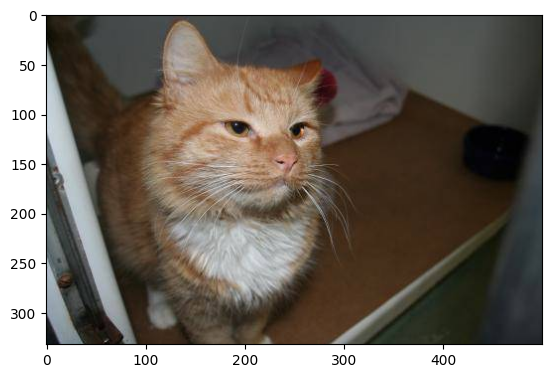

In [4]:
plt.imshow(im)

In [5]:
im.shape

(332, 500, 3)

In [6]:
i, j = 50, 50
cropped_im = im[i:i + 224, j:j + 224, :]

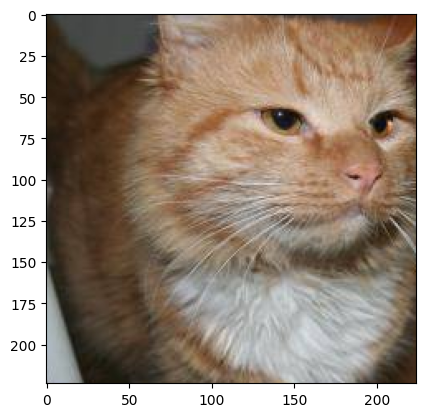

In [7]:
plt.imshow(cropped_im)

In [8]:
cropped_im.shape

(224, 224, 3)

In [9]:
processed_im = tf.keras.applications.resnet50.preprocess_input(tf.cast(cropped_im, tf.float32))

In [10]:
processed_im.shape

TensorShape([224, 224, 3])

In [11]:
processed_im[np.newaxis, ...].shape

TensorShape([1, 224, 224, 3])

In [12]:
probs = network(processed_im[np.newaxis, ...])

<StemContainer object of 3 artists>

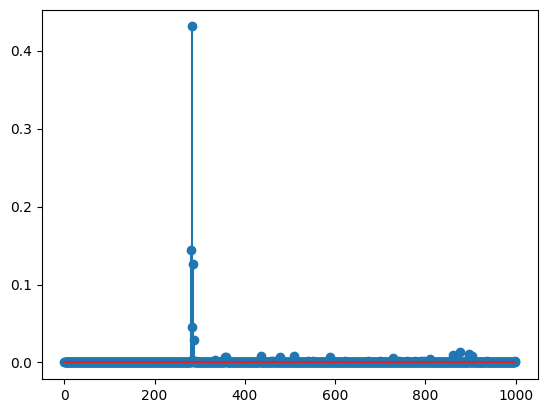

In [13]:
plt.stem(probs.numpy().flatten())

In [14]:
np.argmax(probs)

282

# Using a pre-trained network as a feature extractor

In [15]:
network.layers

In [16]:
network.layers[-2]

In [17]:
feature_extractor = tf.keras.Model(
    inputs=network.input,
    outputs=network.layers[-2].output
)

In [18]:
out = feature_extractor(processed_im[np.newaxis, ...])

In [19]:
out.shape

TensorShape([1, 2048])

In [20]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [21]:
x

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [22]:
x_train, y_train = x[:200], y[:200]
x_test, y_test = x_test[:100], y_test[:100]

In [23]:
x_train.shape

(200, 32, 32, 3)

In [24]:
x_test.shape

(100, 32, 32, 3)

In [25]:
# f_train ---> (200, 2048) # (Batch, channels)
# f_test ---> (100, 2048)

# (224, 224)
# (32, 32)

# tf.image.resize
# tf.keras.applications.resnet50.preprocess_input

In [26]:
resized_x_train = tf.image.resize(x_train, (224, 224))

In [27]:
resized_x_train.shape

TensorShape([200, 224, 224, 3])

In [28]:
def get_embeddings(x):
  """Complete the implementation."""
  resized_x = tf.image.resize(x, (224, 224))
  preprocessed_x = tf.keras.applications.resnet50.preprocess_input(resized_x)
  return feature_extractor(preprocessed_x)

In [29]:
f_train = get_embeddings(x_train)

In [30]:
f_test = get_embeddings(x_test)

In [31]:
f_train = f_train.numpy()
y_train = y_train.flatten()

In [32]:
f_test = f_test.numpy()
y_test = y_test.flatten()

In [33]:
print(f_train.shape, y_train.shape)
print(f_test.shape, y_test.shape)

(200, 2048) (200,)
(100, 2048) (100,)


# Visualize the embeddings

In [34]:
# Dimensionality reduction. -> PCA, LLE, Isomap, t-SNE
import sklearn.manifold
vals = sklearn.manifold.TSNE(2).fit_transform(f_train)

In [35]:
vals.shape

(200, 2)

In [36]:
import seaborn as sns

<Axes: >

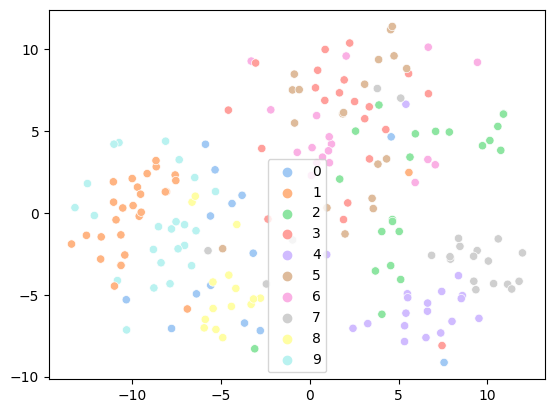

In [37]:
sns.scatterplot(x=vals[:, 0], y=vals[:, 1], hue=y_train, palette='pastel')

# kNN classification with k=1

In [38]:
print(f_test.shape)
print(f_train.shape)

(100, 2048)
(200, 2048)


In [39]:
# Do NOT do this
a, b = len(f_test), len(f_train)
m = np.zeros((a, b))
for i in range(a):
  for j in range(b):
    m[i, j] = np.sum((f_test[i] - f_train[j]) ** 2.0 )

In [40]:
# m[i, j] = || f_test(i) - f_train(j) || ^ 2
#         = ||f_test(i)||^2 + ||f_train(j)||^2 - 2 <f_test(i), f_test(j)>
#         =     a    +    b     -     2*c

In [41]:
a = np.sum(f_test ** 2.0, axis=1)
b = np.sum(f_train ** 2.0, axis=1)
c = np.matmul(f_test, f_train.T)

In [42]:
m = np.reshape(a, (100, 1)) + np.reshape(b, (1, 200)) - 2 * c

In [43]:
import scipy.spatial

In [44]:
m2 = scipy.spatial.distance.cdist(f_test, f_train)  # This is the same as sqrt(m)

In [45]:
m.shape

(100, 200)

In [46]:
idx_of_nn = np.argmin(m, axis=1)

In [47]:
idx_of_nn.shape

(100,)

In [48]:
y_predict = y_train[idx_of_nn]

In [49]:
np.mean(y_test == y_predict)

0.65